In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
anime_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Anime Recommendation Engine/Anime Datasets/Animes2023.csv')

In [ ]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    23363 non-null  int64  
 1   anime_id      23363 non-null  float64
 2   Name          23363 non-null  object 
 3   English name  23363 non-null  object 
 4   Score         23363 non-null  float64
 5   Genres        23363 non-null  object 
 6   Synopsis      23363 non-null  object 
 7   Type          23363 non-null  object 
 8   Episodes      23363 non-null  float64
 9   Aired         23363 non-null  object 
 10  Status        23363 non-null  object 
 11  Rating        23363 non-null  object 
 12  Rank          23363 non-null  float64
 13  Popularity    23363 non-null  float64
 14  Favorites     23363 non-null  float64
 15  Scored By     23363 non-null  float64
 16  Members       23363 non-null  float64
 17  Image URL     23363 non-null  object 
 18  Studios       23363 non-nu

Columns:-
1. **anime_id:** Unique ID for each anime.
2. **Name:** The name of the anime in its original language.
3. **English name:** The English name of the anime.
4. **Score:** The score or rating given to the anime.
5. **Genres:** The genres of the anime, separated by commas.
6. **Synopsis:** A brief description or summary of the anime's plot.
7. **Type:** The type of the anime (e.g., TV series, movie, OVA, etc.).
8. **Episodes:** The number of episodes in the anime.
9. **Aired:** The dates when the anime was aired.
10. **Status:** The status of the anime (e.g., Finished Airing, Currently Airing, etc.).
11. **Studios:** The animation studios that worked on the anime.
12. **Source:** The source material of the anime (e.g., manga, light novel, original).
13. **Rating:** The age rating of the anime.
14. **Rank:** The rank of the anime based on popularity or other criteria.
15. **Popularity:** The popularity rank of the anime.
16. **Favorites**: The number of times the anime was marked as a favorite by users.
17. **Scored By:** The number of users who scored the anime.
18. **Members:** The number of members who have added the anime to their list on the platform.
19. **Image URL:** The URL of the anime's image or poster.

Weighted Score = (v / (v + m)) * S + (m / (v + m)) * C
S = Average score for the anime/manga
v = Number users giving a score for the anime/manga †
m = Minimum number of scored users required to get a calculated score
C = The mean score across the entire Anime/Manga database


1. Stage 1:- Sorting Based on Each Col

In [ ]:

columns_to_sort = ['Score', 'Favorites', 'Scored By', 'Members', 'Rank', 'Popularity']
top_20_animes = {}
# Loop through each column and get the top 20 animes
for column in columns_to_sort:
    if column in ['Rank', 'Popularity']:
        # Ignore rows with zero values and sort in ascending order
        filtered_df = anime_df[anime_df[column] > 0]
        top_20_animes[column] = filtered_df.nsmallest(20, column)
    else:
        top_20_animes[column] = anime_df.nlargest(20, column)

# Display the results
for column, top_animes in top_20_animes.items():
    print(f"\nTop 20 Animes Based on {column}:\n")
    print(top_animes[['anime_id', 'Name', column]])


Top 20 Animes Based on Score:

       anime_id                                               Name  Score
3425     5114.0                   Fullmetal Alchemist: Brotherhood   9.10
4917     9253.0                                        Steins;Gate   9.07
15257   41467.0                          Bleach: Sennen Kessen-hen   9.07
8821    28977.0                                           Gintama°   9.06
13588   38524.0                 Shingeki no Kyojin Season 3 Part 2   9.05
16183   43608.0         Kaguya-sama wa Kokurasetai: Ultra Romantic   9.05
20878   51535.0  Shingeki no Kyojin: The Final Season - Kankets...   9.05
5196     9969.0                                           Gintama'   9.04
5619    11061.0                             Hunter x Hunter (2011)   9.04
14222   39486.0                                 Gintama: The Final   9.04
6332    15417.0                                Gintama': Enchousen   9.03
718       820.0                               Ginga Eiyuu Densetsu   9.02
15834 

Note: Zero Value Handling everywhere

2. Trying Out a Hybrid Model

In [ ]:
# Define weights
weights = {
    "score": 0.4,   # Weight for Base Weighted Score
    "members": 0.2, # Weight for Members
    "favorites": 0.2, # Weight for Favorites
    "rank": 0.1,    # Weight for Rank
    "popularity": 0.1 # Weight for Popularity
}

In [ ]:
def calculate_hybrid_weighted_score(df, weights, m=200, K=20):
    """
    Calculate the Hybrid Weighted Score for anime recommendations.
    - weights: Dictionary containing weights for each factor.
    - m: Minimum number of scored users required.
    - K: Number of top recommendations to return.
    """
    # Compute mean score across the entire database
    C = df['Score'].mean()

    # Compute the base weighted score for each anime
    v = df['Scored By']
    S = df['Score']
    base_weighted_score = (
        (v / (v + m).replace(0, np.nan)) * S +
        (m / (v + m).replace(0, np.nan)) * C
    ).fillna(0)

    # Normalize relevant columns
    cols_to_normalize = ['Members', 'Favorites', 'Rank', 'Popularity']
    normalized_cols = {}
    for col in cols_to_normalize:
        max_val = df[col].max()
        min_val = df[col].min()
        # Avoid division by zero when max_val == min_val
        if max_val != min_val:
            normalized_cols[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_cols[col] = np.zeros_like(df[col])

    # Calculate the hybrid weighted score
    hybrid_weighted_score = (
        weights['score'] * base_weighted_score +
        weights['members'] * normalized_cols['Members'] +
        weights['favorites'] * normalized_cols['Favorites'] -
        weights['rank'] * normalized_cols['Rank'] -
        weights['popularity'] * normalized_cols['Popularity']
    )

    # Select necessary columns for recommendations
    result = df[['anime_id', 'Name']].copy()
    result['Hybrid_Weighted_Score'] = hybrid_weighted_score

    # Sort by the hybrid weighted score
    top_k = result.sort_values(by='Hybrid_Weighted_Score', ascending=False).head(K).reset_index(drop=True)

    return top_k

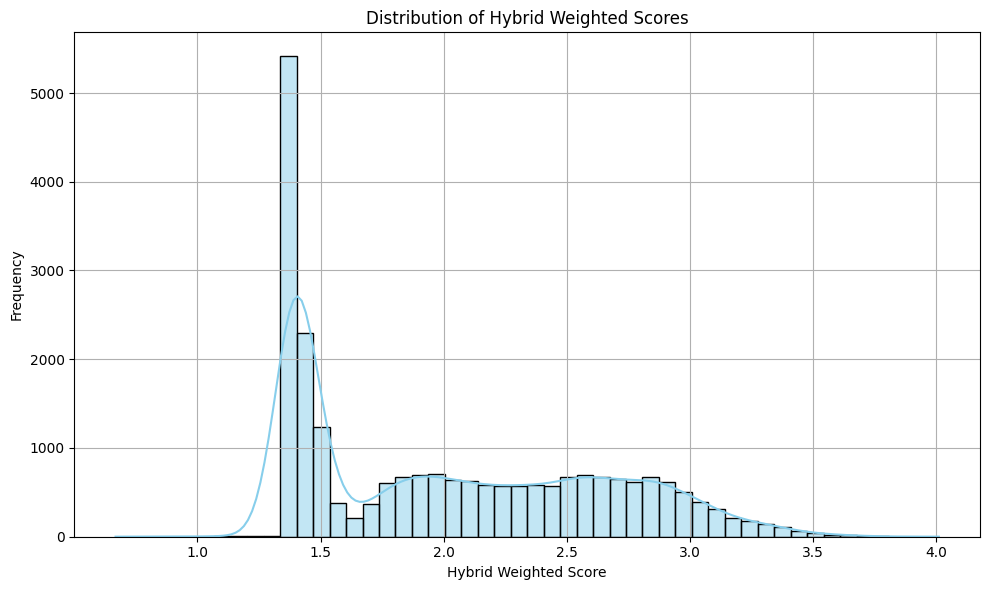

In [ ]:
# Calculate Hybrid Weighted Score and get top 20 recommendations
top_animes = calculate_hybrid_weighted_score(anime_df, weights, m=100, K=25000)

plt.figure(figsize=(10, 6))
sns.histplot(top_animes['Hybrid_Weighted_Score'], kde=True, color='skyblue', bins=50)
plt.title('Distribution of Hybrid Weighted Scores')
plt.xlabel('Hybrid Weighted Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print('Top Recommended animes')
top_animes

Top Recommended animes


,Unnamed: 0,anime_id,Name,English name,Score,Genres,Synopsis,Type,Episodes,Aired,Status,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL,Studios,Source
6504,6504,16498.0,Shingeki no Kyojin,Attack on Titan,8.54,"Action, Award Winning, Drama, Suspense","Centuries ago, mankind was slaughtered to near...",TV,25.0,2013,Finished Airing,R - 17+ (violence & profanity),107.0,1.0,163844.0,2660903.0,3744541.0,https://cdn.myanimelist.net/images/anime/10/47...,Wit Studio,Manga
1328,1328,1535.0,Death Note,Death Note,8.62,"Supernatural, Suspense","Brutal murders, petty thefts, and senseless vi...",TV,37.0,2006,Finished Airing,R - 17+ (violence & profanity),74.0,2.0,167586.0,2619479.0,3713315.0,https://cdn.myanimelist.net/images/anime/9/945...,Madhouse,Manga
3425,3425,5114.0,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,9.10,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,64.0,2009,Finished Airing,R - 17+ (violence & profanity),1.0,3.0,217606.0,2020030.0,3176556.0,https://cdn.myanimelist.net/images/anime/1208/...,Bones,Manga
9325,9325,30276.0,One Punch Man,One Punch Man,8.50,"Action, Comedy",The seemingly unimpressive Saitama has a rathe...,TV,12.0,2015,Finished Airing,R - 17+ (violence & profanity),127.0,4.0,62408.0,2131099.0,3058666.0,https://cdn.myanimelist.net/images/anime/12/76...,Madhouse,Manga
5746,5746,11757.0,Sword Art Online,Sword Art Online,7.20,"Action, Adventure, Fantasy, Romance",Ever since the release of the innovative Nerve...,TV,25.0,2012,Finished Airing,PG-13 - Teens 13 or older,3055.0,5.0,67014.0,2072240.0,2951821.0,https://cdn.myanimelist.net/images/anime/11/39...,A-1 Pictures,Novel
10020,10020,31964.0,Boku no Hero Academia,My Hero Academia,7.89,Action,"The appearance of ""quirks,"" newly discovered s...",TV,13.0,2016,Finished Airing,PG-13 - Teens 13 or older,740.0,6.0,53389.0,1977824.0,2882333.0,https://cdn.myanimelist.net/images/anime/10/78...,Bones,Manga
13284,13284,38000.0,Kimetsu no Yaiba,Demon Slayer: Kimetsu no Yaiba,8.50,"Action, Award Winning, Fantasy","Ever since the death of his father, the burden...",TV,26.0,2019,Finished Airing,R - 17+ (violence & profanity),126.0,7.0,88375.0,1943121.0,2808712.0,https://cdn.myanimelist.net/images/anime/1286/...,ufotable,Manga
10,10,20.0,Naruto,Naruto,7.99,"Action, Adventure, Fantasy","Moments prior to Naruto Uzumaki's birth, a hug...",TV,220.0,2002,Finished Airing,PG-13 - Teens 13 or older,599.0,8.0,76343.0,1883772.0,2717330.0,https://cdn.myanimelist.net/images/anime/13/17...,Pierrot,Manga
7622,7622,22319.0,Tokyo Ghoul,Tokyo Ghoul,7.79,"Action, Fantasy, Horror",A sinister threat is invading Tokyo: flesh-eat...,TV,12.0,2014,Finished Airing,R - 17+ (violence & profanity),933.0,9.0,49098.0,1791023.0,2699241.0,https://cdn.myanimelist.net/images/anime/1498/...,Pierrot,Manga
5619,5619,11061.0,Hunter x Hunter (2011),Hunter x Hunter,9.04,"Action, Adventure, Fantasy",Hunters devote themselves to accomplishing haz...,TV,148.0,2011,Finished Airing,PG-13 - Teens 13 or older,10.0,10.0,200265.0,1651790.0,2656870.0,https://cdn.myanimelist.net/images/anime/1337/...,Madhouse,Manga


3. Adding a time delay factor to the hybrid model

preprocessing Aired column

In [ ]:
import re

# extract the first 4-digit year from the 'Aired' column
def extract_year(aired_str):
    if 'Not available' in aired_str:
        return 'UNKNOWN'

    year_match = re.search(r'\b(\d{4})\b', aired_str)
    if year_match:
        return year_match.group(1)
    return 'UNKNOWN'

In [ ]:
# Apply the function to the 'Aired' column
anime_df['Aired'] = anime_df['Aired'].apply(extract_year)

In [ ]:
anime_df.columns

Index(['anime_id', 'Name', 'English name', 'Score', 'Genres', 'Synopsis',
       'Type', 'Episodes', 'Aired', 'Status', 'Rating', 'Rank', 'Popularity',
       'Favorites', 'Scored By', 'Members', 'Image URL', 'Studios', 'Source',
       'Aired Year'],
      dtype='object')

Applying Linear Time Delay

In [ ]:
import datetime

In [ ]:
def calculate_hybrid_weighted_score_linear(df, m=200, K=20):
    """
    Calculate the Hybrid Weighted Score for anime recommendations.
    - weights: Dictionary containing weights for each factor.
    - m: Minimum number of scored users required.
    - K: Number of top recommendations to return.
    """
    weights = {
        "score": 0.4,   # Weight for Base Weighted Score
        "members": 0.2, # Weight for Members
        "favorites": 0.1, # Weight for Favorites
        "rank": 0.1,    # Weight for Rank
        "popularity": 0.1, # Weight for Popularity
        "time_delay": 0.1 # Weight for Time Delay
    }

    C = df['Score'].mean()
    v = df['Scored By']
    S = df['Score']
    base_weighted_score = (
        (v / (v + m).replace(0, np.nan)) * S +
        (m / (v + m).replace(0, np.nan)) * C
    ).fillna(0)

    # Normalize relevant columns
    cols_to_normalize = ['Members', 'Favorites', 'Rank', 'Popularity']
    normalized_cols = {}
    for col in cols_to_normalize:
        max_val = df[col].max()
        min_val = df[col].min()

        if max_val != min_val:
            normalized_cols[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_cols[col] = np.zeros_like(df[col])

    #linear time delay
    current_year = datetime.datetime.now().year
    a = 0.1
    year_df = pd.DataFrame(df['Aired'])
    year_df['Time Delay Factor'] = anime_df['Aired'].apply(
        lambda x: a * (current_year - int(x)) if pd.notnull(x) and x != 'UNKNOWN' else 0
        )

    # Calculate the hybrid weighted score
    hybrid_weighted_score = (
        weights['score'] * base_weighted_score +
        weights['members'] * normalized_cols['Members'] +
        weights['favorites'] * normalized_cols['Favorites'] -
        weights['rank'] * normalized_cols['Rank'] -
        weights['popularity'] * normalized_cols['Popularity'] -
        weights['time_delay'] * year_df['Time Delay Factor']
    )

    # Select necessary columns for recommendations
    result = df[['anime_id', 'Name']].copy()
    result['Hybrid_Weighted_Score'] = hybrid_weighted_score

    # Sort by the hybrid weighted score and return top K recommendations
    top_k = result.sort_values(by='Hybrid_Weighted_Score', ascending=False).head(K).reset_index(drop=True)

    return top_k

In [ ]:
# Calculate Hybrid Weighted Score and get top 20 recommendations
top_animes = calculate_hybrid_weighted_score_linear(anime_df, weights, m=100, K=25)

print('Top Recommended animes')
top_animes

Top Recommended animes


,anime_id,Name,Hybrid_Weighted_Score
0,5114.0,Fullmetal Alchemist: Brotherhood,3.759546
1,11061.0,Hunter x Hunter (2011),3.719726
2,9253.0,Steins;Gate,3.712205
3,38524.0,Shingeki no Kyojin Season 3 Part 2,3.707502
4,43608.0,Kaguya-sama wa Kokurasetai: Ultra Romantic,3.655941
5,28851.0,Koe no Katachi,3.651197
6,32281.0,Kimi no Na wa.,3.638553
7,41467.0,Bleach: Sennen Kessen-hen,3.637219
8,51535.0,Shingeki no Kyojin: The Final Season - Kankets...,3.634179
9,52034.0,"""Oshi no Ko""",3.615023


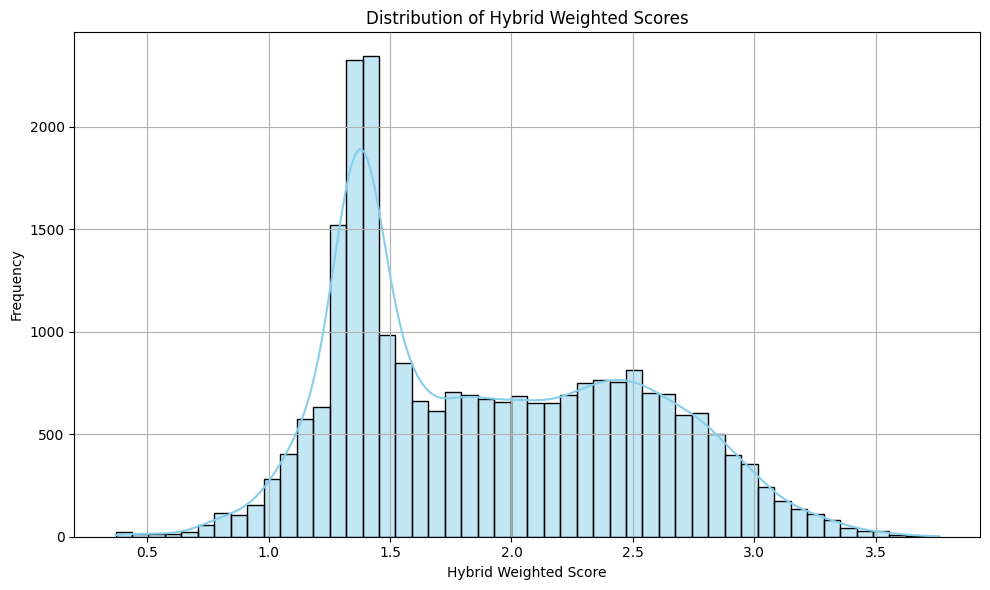

In [ ]:
# Calculate Hybrid Weighted Score and get top 20 recommendations
top_animes = calculate_hybrid_weighted_score_linear(anime_df, weights, m=100, K=25000)

plt.figure(figsize=(10, 6))
sns.histplot(top_animes['Hybrid_Weighted_Score'], kde=True, color='skyblue', bins=50)
plt.title('Distribution of Hybrid Weighted Scores')
plt.xlabel('Hybrid Weighted Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

Apply Exponential Time Delay

In [ ]:
weights = {
    "score": 0.4,   # Weight for Base Weighted Score
    "members": 0.2, # Weight for Members
    "favorites": 0.1, # Weight for Favorites
    "rank": 0.1,    # Weight for Rank
    "popularity": 0.1, # Weight for Popularity
    "time_delay": 0.1 # Weight for Time Delay
}

In [ ]:
def calculate_hybrid_weighted_score_expo(df, weights, m=200, K=20):
    """
    - weights: Dictionary containing weights for each factor.
    - m: Minimum number of scored users required.
    - K: Number of top recommendations to return.
    """

    C = df['Score'].mean()
    v = df['Scored By']
    S = df['Score']
    base_weighted_score = (
        (v / (v + m).replace(0, np.nan)) * S +
        (m / (v + m).replace(0, np.nan)) * C
    ).fillna(0)

    # Normalize relevant columns
    cols_to_normalize = ['Members', 'Favorites', 'Rank', 'Popularity']
    normalized_cols = {}
    for col in cols_to_normalize:
        max_val = df[col].max()
        min_val = df[col].min()

        if max_val != min_val:
            normalized_cols[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_cols[col] = np.zeros_like(df[col])

    # Exponential time delay
    current_year = datetime.datetime.now().year
    a = 0.1  # Scaling factor
    b = 0.05  # Rate parameter for exponential function

    # Apply exponential time delay calculation
    year_df = pd.DataFrame(df['Aired'])
    year_df['Time Delay Factor'] = df['Aired'].apply(
        lambda x: -a * np.exp(b * (current_year - int(x))) if pd.notnull(x) and x != 'UNKNOWN' else 0
    )

    # Calculate the hybrid weighted score
    hybrid_weighted_score = (
        weights['score'] * base_weighted_score +
        weights['members'] * normalized_cols['Members'] +
        weights['favorites'] * normalized_cols['Favorites'] -
        weights['rank'] * normalized_cols['Rank'] -
        weights['popularity'] * normalized_cols['Popularity'] -
        weights['time_delay'] * year_df['Time Delay Factor']
    )

    # Select necessary columns for recommendations
    result = df[['anime_id', 'Name']].copy()
    result['Hybrid_Weighted_Score'] = hybrid_weighted_score

    # Sort by the hybrid weighted score and return top K recommendations
    top_k = result.sort_values(by='Hybrid_Weighted_Score', ascending=False).head(K).reset_index(drop=True)

    return top_k

In [ ]:
# Calculate Hybrid Weighted Score and get top 20 recommendations
top_animes = calculate_hybrid_weighted_score_expo(anime_df, weights, m=100, K=25)

print('Top Recommended animes')
top_animes

Top Recommended animes


,anime_id,Name,Hybrid_Weighted_Score
0,6654.0,Namakura Gatana,4.216341
1,23189.0,Dekobou Shingachou: Meian no Shippai,4.214662
2,17387.0,Imokawa Mukuzo: Genkanban no Maki,3.999314
3,10757.0,Kachikachi Yama,3.951981
4,5114.0,Fullmetal Alchemist: Brotherhood,3.930716
5,11061.0,Hunter x Hunter (2011),3.868881
6,18457.0,Hanasaka Jijii,3.865315
7,22511.0,Kobutori,3.862214
8,9253.0,Steins;Gate,3.861360
9,10742.0,Saru to Kani no Gassen,3.859547


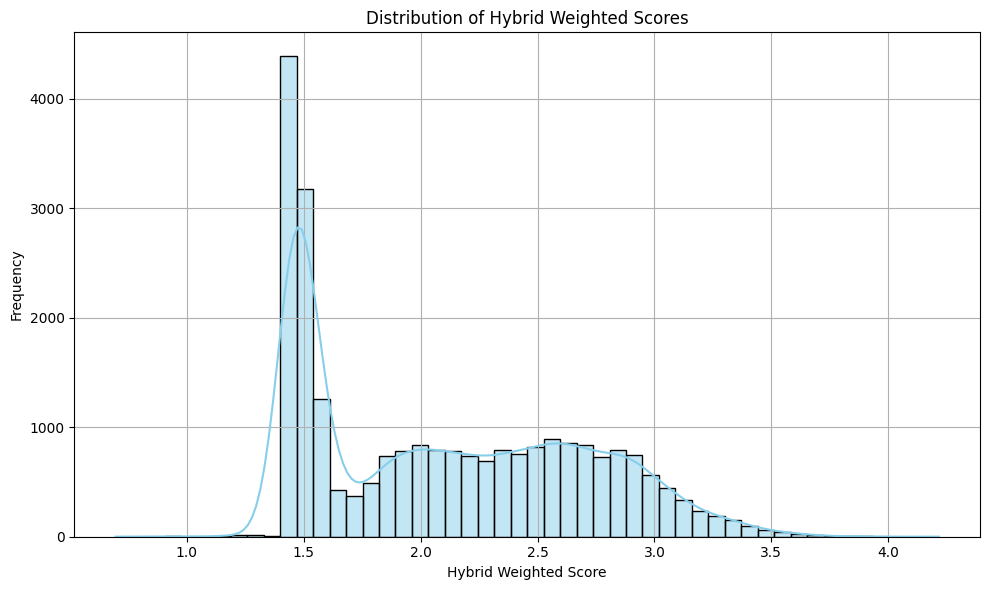

In [ ]:
# Calculate Hybrid Weighted Score and get top 20 recommendations
top_animes = calculate_hybrid_weighted_score_expo(anime_df, weights, m=100, K=25000)

plt.figure(figsize=(10, 6))
sns.histplot(top_animes['Hybrid_Weighted_Score'], kde=True, color='skyblue', bins=50)
plt.title('Distribution of Hybrid Weighted Scores')
plt.xlabel('Hybrid Weighted Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

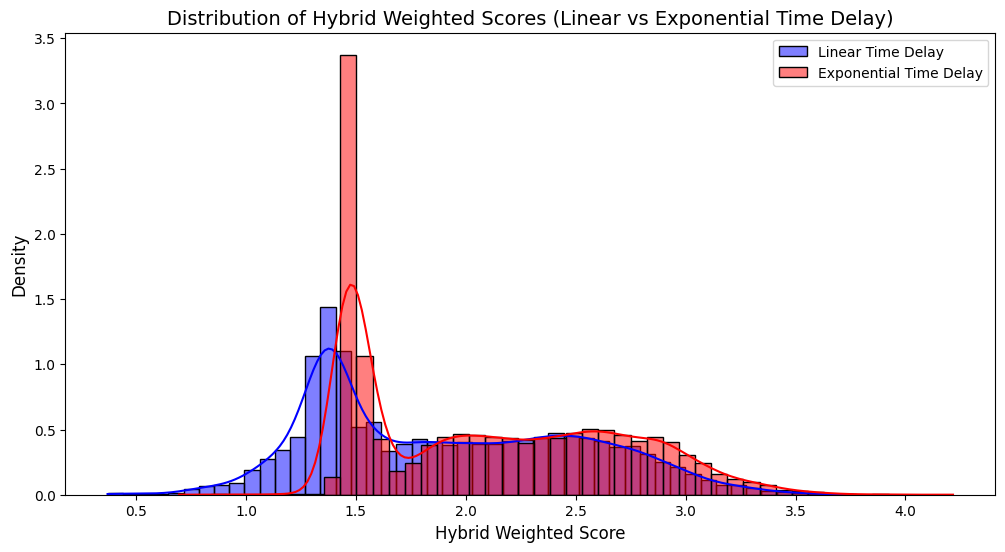

In [ ]:
linear_score=calculate_hybrid_weighted_score_linear(anime_df, weights, m=100, K=len(anime_df))
expo_score=calculate_hybrid_weighted_score_expo(anime_df, weights, m=100, K=len(anime_df))

# Plotting the distribution of the scores
plt.figure(figsize=(12, 6))
# Plot the Linear Time Delay Score distribution
sns.histplot(linear_score['Hybrid_Weighted_Score'], color='blue', label='Linear Time Delay', kde=True, stat='density')
# Plot the Exponential Time Delay Score distribution
sns.histplot(expo_score['Hybrid_Weighted_Score'], color='red', label='Exponential Time Delay', kde=True, stat='density')
# Add labels and title
plt.title('Distribution of Hybrid Weighted Scores (Linear vs Exponential Time Delay)', fontsize=14)
plt.xlabel('Hybrid Weighted Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Show plot
plt.show()

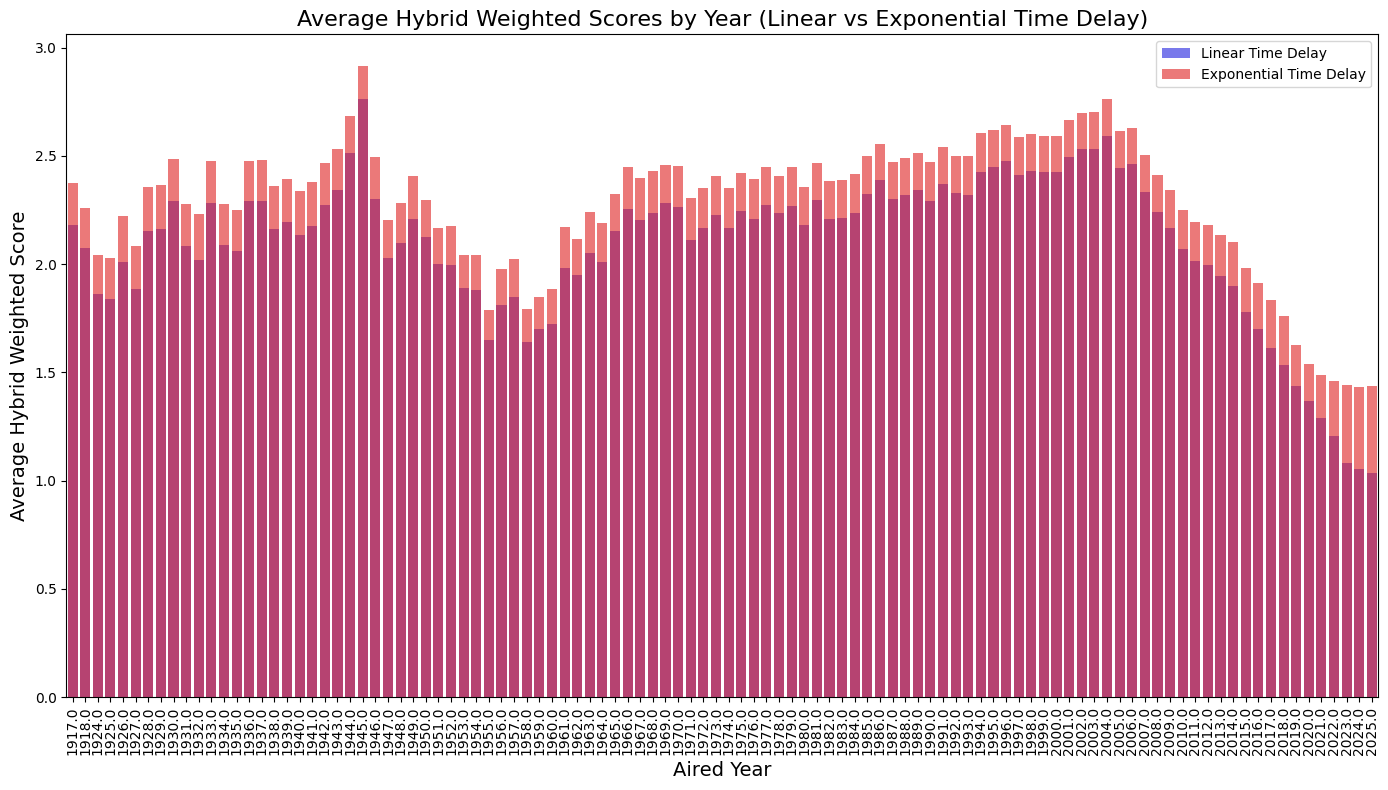

In [ ]:
linear_score['Aired Year'] = anime_df['Aired']
expo_score['Aired Year'] = anime_df['Aired']

linear_score['Aired Year'] = pd.to_numeric(linear_score['Aired Year'], errors='coerce')
expo_score['Aired Year'] = pd.to_numeric(expo_score['Aired Year'], errors='coerce')

avg_linear_score = linear_score.groupby('Aired Year')['Hybrid_Weighted_Score'].mean().reset_index()
avg_expo_score = expo_score.groupby('Aired Year')['Hybrid_Weighted_Score'].mean().reset_index()

avg_scores = pd.merge(avg_linear_score, avg_expo_score, on='Aired Year', suffixes=('_linear', '_expo'))

# Plotting the comparison of average scores by year
plt.figure(figsize=(14, 8))

sns.barplot(x='Aired Year', y='Hybrid_Weighted_Score_linear', data=avg_scores, color='blue', label='Linear Time Delay', alpha=0.6)
sns.barplot(x='Aired Year', y='Hybrid_Weighted_Score_expo', data=avg_scores, color='red', label='Exponential Time Delay', alpha=0.6)

plt.title('Average Hybrid Weighted Scores by Year (Linear vs Exponential Time Delay)', fontsize=16)
plt.xlabel('Aired Year', fontsize=14)
plt.ylabel('Average Hybrid Weighted Score', fontsize=14)
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()